In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import numpy as np
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adam
import pandas
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# disable jax JIT
#jax.config.update("jax_disable_jit", True)

import sys
import os

sys.path.append(os.path.abspath(".."))

from scripts.vigamlss import Normal, Gamma, CustomGPD,DataPreperator, DegenerateNormal, FullCovarianceNormal
from scripts.vigamlss.utils.transformations import TransformationFunctions

2025-01-28 15:26:51.284987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738074411.301351  325706 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738074411.305804  325706 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [85]:
ddbmi_df = pandas.read_csv("../data/dbbmi_data.csv")

Y_data_np = ddbmi_df["bmi"].values
Y_data_jnp = jnp.array(Y_data_np)
X_data_np = ddbmi_df["age"].values
X_data_jnp = jnp.array(X_data_np)

XDesign = DataPreperator(
    "xDesign", X_data_jnp, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
K = XDesign.K

lambda_mu = Gamma("lambda_mu", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_mu = DegenerateNormal("gammas_mu", K, lambda_mu)
beta_0_mu = Normal("beta_0_mu", jnp.array([0.0]), jnp.array([100.0]), 1)
lambda_scale = Gamma("lambda_scale", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_scale = DegenerateNormal("gammas_scale", K, lambda_scale)
beta_0_scale = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([100.0]), 1)
y = Gamma("y", beta_0_mu + XDesign @ gammas_mu, beta_0_scale + XDesign @ gammas_scale, responses=Y_data_jnp)
results = y.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=500,
    mb_size=32,
    lr=0.01,
    max_norm=5.0,
    clip_min_max_enabled=False,
    prng_key=PRNGKey(0),
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_77330/1831295793.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


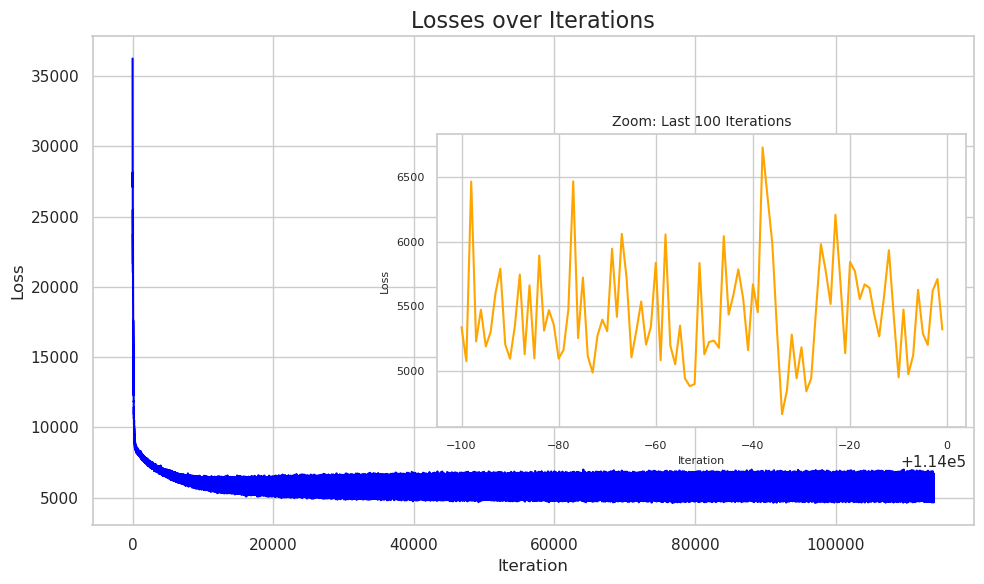

In [86]:
# Data from your results
num_iterations = results["svi_metadata"]["num_iterations"]
losses = results["losses"]

# Create the main plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

# Add labels and title
ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

# Add inset for zoomed-in view of the last 100 iterations
ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

# Display the plot
plt.tight_layout()
plt.show()

In [87]:
chol_lower_tril = results["scale_vi_matrix"]
covariance_matrix_jnp = jnp.dot(chol_lower_tril, chol_lower_tril.T)
diagonal = jnp.diag(covariance_matrix_jnp)
diagonal

Array([2.11083527e+01, 8.06596184e+00, 1.18535595e+01, 1.21996078e+01,
       1.11974688e+01, 6.53948545e+00, 3.14848280e+00, 1.22993577e+00,
       2.85590601e+00, 8.58308315e+00, 1.48036299e+01, 2.41881466e+01,
       3.59136963e+01, 4.67459030e+01, 5.79102783e+01, 7.18089828e+01,
       8.58569336e+01, 9.88675461e+01, 1.05018517e+02, 1.14271461e+02,
       1.34287354e+02, 1.06827274e-01, 3.20502441e+02, 8.39570314e-02,
       1.13439061e-01, 1.17817514e-01, 1.28243059e-01, 1.32750317e-01,
       1.31018296e-01, 1.15204789e-01, 1.04582645e-01, 9.17006806e-02,
       1.04297712e-01, 1.22282311e-01, 1.55265778e-01, 1.91917747e-01,
       2.19033659e-01, 2.57524014e-01, 2.82263905e-01, 3.19398910e-01,
       3.60960007e-01, 4.47504818e-01, 6.67233646e-01, 1.19101548e+00,
       1.14471808e-01, 1.03454769e+00], dtype=float32)

<Figure size 1200x700 with 0 Axes>

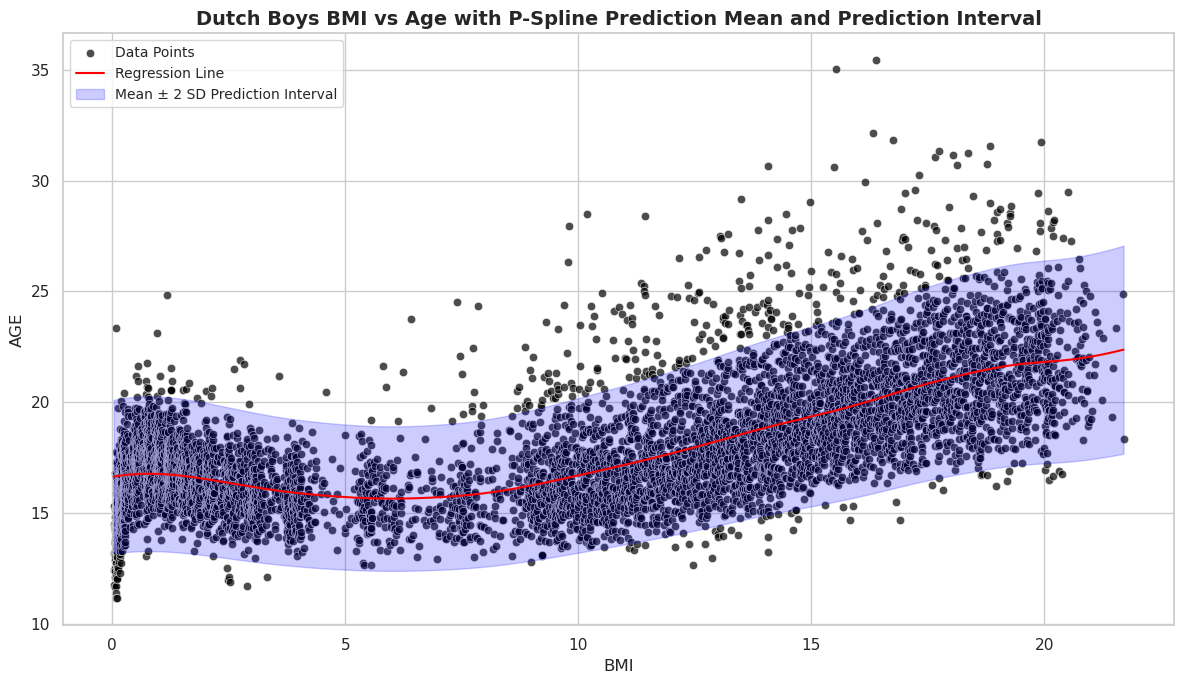

In [89]:
# Response is Gamma Distributed Case
beta_0_mu = results["transformed_loc_vi_parameters"]["beta_0_mu"]
gammas_mu = results["transformed_loc_vi_parameters"]["gammas_mu"]
beta_0_scale = results["transformed_loc_vi_parameters"]["beta_0_scale"]
gammas_scale = results["transformed_loc_vi_parameters"]["gammas_scale"]

X_min, X_max = X_data_jnp.min(), X_data_jnp.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign", X_line, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
linear_predictor_concentration = TransformationFunctions.softplus(beta_0_mu + X_line_design.matrix @ gammas_mu)
linear_predictor_rate = TransformationFunctions.softplus(beta_0_scale + X_line_design.matrix @ gammas_scale)

mean_line = linear_predictor_concentration / linear_predictor_rate
variance_line = linear_predictor_concentration / (linear_predictor_rate ** 2)
sd_line = jnp.sqrt(variance_line)

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the plot
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data, y axis label is age, a x axis label is bmi
sns.scatterplot(x=X_data_np, y=Y_data_np, color='black', label='Data Points', alpha=0.7, ax=ax)

# Plot the PsSpline regression line
sns.lineplot(x=X_line, y=mean_line, color='red', label='Regression Line', ax=ax)

# Calculate the standard deviation
Y_lower = mean_line - 2 * sd_line
Y_upper = mean_line + 2 * sd_line

# Add the two standard deviation interval
ax.fill_between(X_line, Y_lower, Y_upper, color='blue', alpha=0.2, 
                label='Mean ± 2 SD Prediction Interval')

# Improve the legend
ax.legend(fontsize=10, loc='upper left')

# Customize the plot
ax.set_xlabel('BMI', fontsize=12)
ax.set_ylabel('AGE', fontsize=12)
ax.set_title('Dutch Boys BMI vs Age with P-Spline Prediction Mean and Prediction Interval', fontsize=14, fontweight='bold')

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()

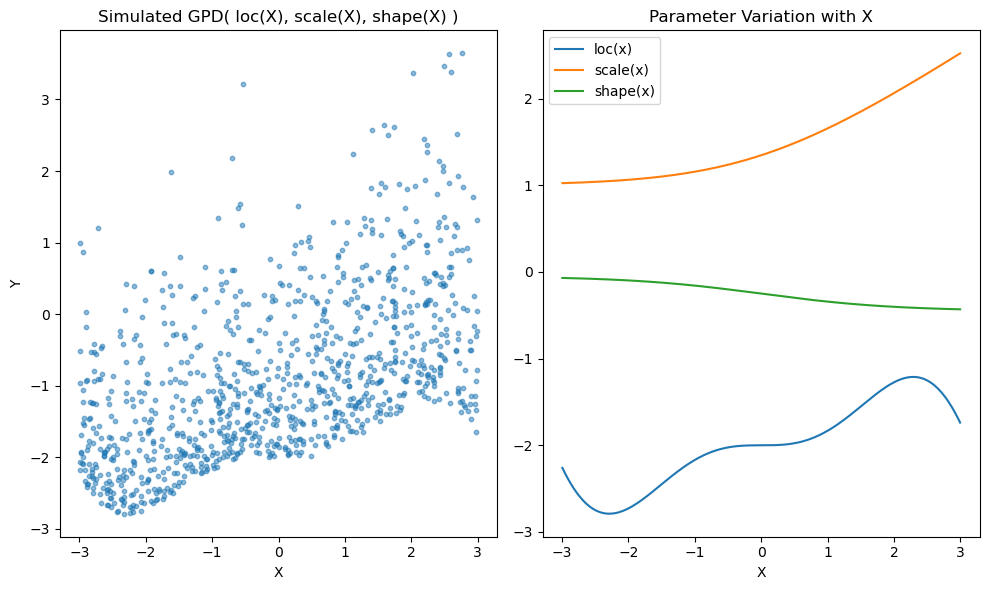

In [25]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GPD = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    """
    Location can be any real number. 
    For example: loc(x) = 0.2 * x^2 * sin(x) - 2
    """
    return 0.2 * x**2 * jnp.sin(x) - 2 

def scale_fn(x):
    """
    Scale must be strictly positive. 
    Uses softplus to ensure positivity.
    Let's do scale(x) = 1 + softplus(0.2*x).
    This will remain > 1.0 for large x and approach 1.0 for negative x.
    """
    return 1.0 + TransformationFunctions.softplus(x) * 0.5

def shape_fn(x):
    """
    Shape can be any real number. 
    We'll use a scaled tanh() so it transitions from negative to positive.
    For example, shape(x) = 0.3 * tanh(0.5*x).
    This yields shape in (-0.3, 0.3).
    """
    return -0.2 * jnp.tanh(0.5 * x) - 0.25

# Vectorize param values for each sample
loc_vals   = loc_fn(X_GPD)
scale_vals = scale_fn(X_GPD)
shape_vals = shape_fn(X_GPD)

# ------------------------------------------------
# 3) Construct a *batch* of GPDs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gpd_dists = tfd.GeneralizedPareto(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GPD_tf = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GPD = jnp.array(Y_GPD_tf)

# ------------------------------------------------
# 5) Optional: Visualization
# ------------------------------------------------
plt.figure(figsize=(10,6))

# Plot the (X, Y) cloud
plt.subplot(1,2,1)
plt.scatter(X_GPD, Y_GPD, alpha=0.5, s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Simulated GPD( loc(X), scale(X), shape(X) )")

# Plot how each parameter depends on X
xs_sorted = jnp.sort(X_GPD)
loc_sorted = loc_fn(xs_sorted)
scale_sorted = scale_fn(xs_sorted)
shape_sorted = shape_fn(xs_sorted)

plt.subplot(1,2,2)
plt.plot(xs_sorted, loc_sorted, label="loc(x)")
plt.plot(xs_sorted, scale_sorted, label="scale(x)")
plt.plot(xs_sorted, shape_sorted, label="shape(x)")
plt.xlabel("X")
plt.title("Parameter Variation with X")
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
XDesignGPD = DataPreperator(
    "xDesign",
    X_GPD,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10,
)()
K = XDesignGPD.K

lambda_loc_GPD = Gamma("lambda_loc", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_loc_GPD = DegenerateNormal("gammas_loc", K, lambda_loc_GPD)
beta_0_loc_GPD = Normal("beta_0_loc", jnp.array([0.0]), jnp.array([100.0]), 1)
lambda_scale_GPD = Gamma("lambda_scale", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_scale_GPD = DegenerateNormal("gammas_scale", K, lambda_scale_GPD)
beta_0_scale_GPD = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([100.0]), 1)
lambda_shape_GPD = Gamma("lambda_shape", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_shape_GPD = DegenerateNormal("gammas_shape", K, lambda_shape_GPD)
beta_0_shape_GPD = Normal("beta_0_shape", jnp.array([0.0]), jnp.array([100.0]), 1)
y_GPD = CustomGPD(
    "y",
    beta_0_loc_GPD + XDesignGPD @ gammas_loc_GPD,
    beta_0_scale_GPD + XDesignGPD @ gammas_scale_GPD,
    beta_0_shape_GPD + XDesignGPD @ gammas_shape_GPD,
    responses=Y_GPD,
)
results_GPD = y_GPD.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=10000,
    mb_size=32,
    lr=0.001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    prng_key=PRNGKey(0),
)

/tmp/ipykernel_325706/699216852.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


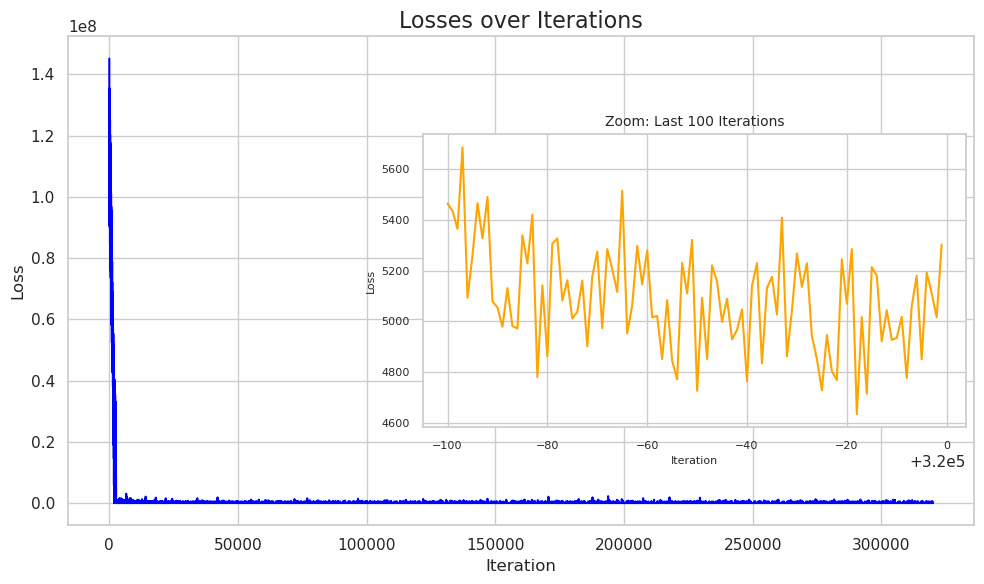

In [62]:
# Data from results GPD
num_iterations = results_GPD["svi_metadata"]["num_iterations"]
losses = results_GPD["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.show()

In [63]:
chol_lower_tril = results_GPD["scale_vi_matrix"]
covariance_matrix_jnp = jnp.dot(chol_lower_tril, chol_lower_tril.T)
diagonal = jnp.diag(covariance_matrix_jnp)
diagonal

Array([2.0873742e-03, 6.3506668e-03, 9.5940806e-04, 2.4569663e-03,
       7.1890564e-03, 1.0581861e-02, 1.0673294e-02, 9.2063099e-03,
       7.0851832e-03, 5.4961997e-03, 7.3417332e-03, 1.9835575e-02,
       1.9255716e-01, 6.4052081e-01, 7.8226101e-01, 1.8726347e-01,
       3.3162482e-02, 1.6644659e-02, 1.4216477e-01, 3.8903588e-01,
       8.2670802e-01, 1.3421433e+00, 1.8759365e+00, 1.9621446e+00,
       2.1524901e+00, 1.6799271e-01, 1.8431696e-01, 5.8791947e-02,
       9.0376295e-02, 1.5960419e-01, 2.0430696e-01, 2.1959400e-01,
       2.3683396e-01, 2.3686123e-01, 2.6402459e-01, 3.3992162e-01,
       6.3353175e-01, 2.0086055e-01, 1.3578257e-01], dtype=float32)

<Figure size 1200x700 with 0 Axes>

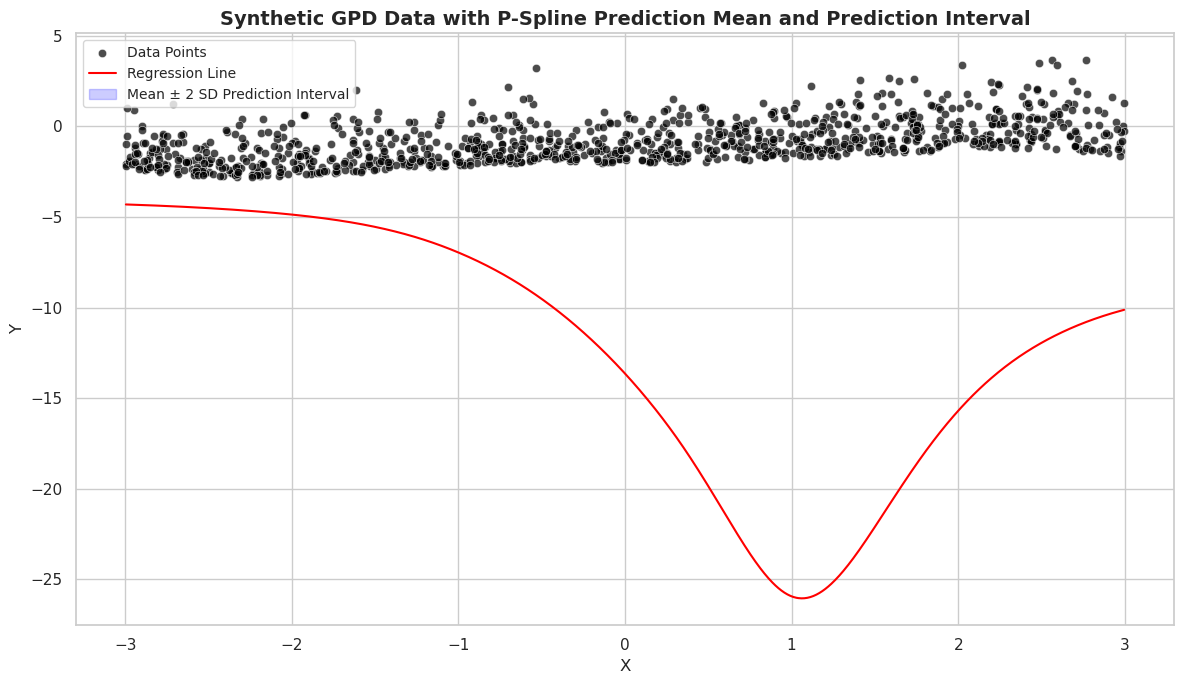

In [64]:
# Response is GPD GAMLSS Distributed Case
beta_0_loc = results_GPD["transformed_loc_vi_parameters"]["beta_0_loc"]
gammas_loc = results_GPD["transformed_loc_vi_parameters"]["gammas_loc"]
beta_0_scale = results_GPD["transformed_loc_vi_parameters"]["beta_0_scale"]
gammas_scale = results_GPD["transformed_loc_vi_parameters"]["gammas_scale"]
beta_0_shape = results_GPD["transformed_loc_vi_parameters"]["beta_0_shape"]
gammas_shape = results_GPD["transformed_loc_vi_parameters"]["gammas_shape"]

X_min, X_max = X_GPD.min(), X_GPD.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10,
)()
linear_predictor_loc = beta_0_loc + X_line_design.matrix @ gammas_loc
linear_predictor_scale = TransformationFunctions.softplus(
    beta_0_scale + X_line_design.matrix @ gammas_scale
)
linear_predictor_shape = beta_0_shape + X_line_design.matrix @ gammas_shape

# GPD_mean
GPD_mean = linear_predictor_loc + (
    linear_predictor_scale / (1 - linear_predictor_shape)
)
# GPD_variance
GPD_variance = linear_predictor_scale**2 / (
    (1 - linear_predictor_shape) ** 2 * (1 - 2 * linear_predictor_shape)
)
# GPD_sd
GPD_sd = jnp.sqrt(GPD_variance)

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

sns.scatterplot(
    x=np.array(X_GPD), y=np.array(Y_GPD), color="black", label="Data Points", alpha=0.7, ax=ax
)

# Plots the PSpline regression line
sns.lineplot(
    x=X_line, y=GPD_mean, color="red", label="Regression Line", ax=ax
)

# Calculate the standard deviation
Y_lower = GPD_mean - 2 * GPD_sd
Y_upper = GPD_mean + 2 * GPD_sd

# Add the two standard deviation interval
ax.fill_between(
    X_line,
    Y_lower,
    Y_upper,
    color="blue",
    alpha=0.2,
    label="Mean ± 2 SD Prediction Interval",
)

ax.legend(fontsize=10, loc="upper left")

ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic GPD Data with P-Spline Prediction Mean and Prediction Interval",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()

plt.show()

<Figure size 1200x700 with 0 Axes>

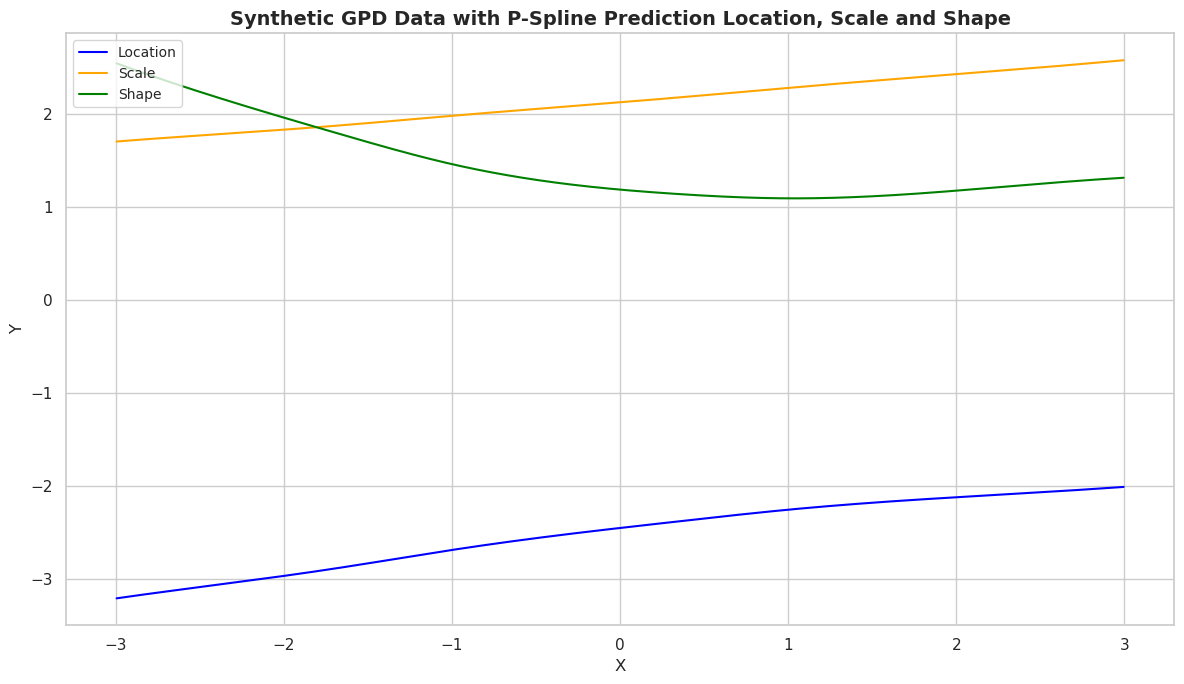

In [66]:
# plot location scale shape predicted curves
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the PSpline regression line
sns.lineplot(x=X_line, y=linear_predictor_loc, color="blue", label="Location", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_scale, color="orange", label="Scale", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_shape, color="green", label="Shape", ax=ax)

# Improve the legend
ax.legend(fontsize=10, loc="upper left")

# Customize the plot
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic GPD Data with P-Spline Prediction Location, Scale and Shape",
    fontsize=14,
    fontweight="bold",
)

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()